In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import jieba as jb
import re
 
df = pd.read_excel('附件2.xlsx')
df.sample(10)


,留言编号,留言用户,留言主题,留言时间,留言详情,一级分类
209,2067,A00072941,A市民办培训机构乱象丛生，温斯顿英语培训强设霸王条款,2019/6/11 0:43:37,\n\t\t\t\t\t\n\t\t\t\t\t本人在温斯顿楚府中心给小孩报名学习英语，并于...,教育文体
431,51251,A0007819,D10县莲花西路合力超市的猪肉是否经过检验检疫？,2019/3/7 14:50:43,\n\t\t\t\t\t\n\t\t\t\t\t莲花西路合力超市猪肉摊长期低于市场价价格销售...,商贸旅游
494,171007,A00029795,G8县乡镇通医务人员的节假日在何方？,2012/9/29 9:23:50,\n\t\t\t\t\t\n\t\t\t\t\t书记： 你好，我们是G8县乡镇卫生院的一名...,卫生计生
9,100825,A0006699,K市域轨道交通规划建议,2017/3/15 20:50:40,\n\t\t\t\t\t\n\t\t\t\t\t 李书记您好，感谢您的阅读。十二五期间，非...,城乡建设
38,18801,A00075703,A7县松雅西地省片区需要配置公立幼儿园,2015/7/15 9:56:08,\n\t\t\t\t\t\n\t\t\t\t\t 松雅西地省片区指的是星沙大道以东，东四路...,城乡建设
364,138971,A00041489,M3县信用社劳务派遣工资只有正式工的百分之二十,2013/8/9 12:30:51,\n\t\t\t\t\t\n\t\t\t\t\t 麻烦龚书记，为我们信用社广大的劳务派遣主...,劳动和社会保障
37,673,A00080647,A2区泰华一村小区第四届非法业委会涉嫌侵占小区业主公共资金,2019/10/24 11:29:02,\n\t\t\t\t\t\n\t\t\t\t\t请求依法监督泰华一村小区第四届非法业主委员会...,城乡建设
237,2168,A00023791,反映长郡A9市实验学校特长生招生名不符实的问题,2019/5/31 0:29:11,\n\t\t\t\t\t\n\t\t\t\t\t2019年5月，长郡A9市实验学校的体育特长...,教育文体
154,15374,A000100346,A市的巿政道路维护质量与水平有待改进,2012/3/2 22:34:46,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的张巿长： A市的巿政道路...,交通运输
448,11352,A000107599,A2区计生办工作人员百般刁难恶意中伤群众,2015/6/11 17:48:12,\n\t\t\t\t\t\n\t\t\t\t\t 我要举报投诉A2区政府计生办工作人员龙雪...,卫生计生


In [15]:
df.shape[0]

495

In [9]:
# 查看是否有空值
df.isnull().sum()

留言编号    0
留言用户    0
留言主题    0
留言时间    0
留言详情    0
一级分类    0
dtype: int64

In [2]:
# 统计一级分类各个分类的数据量
d = {'一级分类':df['一级分类'].value_counts().index, 'count': df['一级分类'].value_counts()}
df_1 = pd.DataFrame(data=d).reset_index(drop=True)
df_1

,count,一级分类
0,104,劳动和社会保障
1,101,城乡建设
2,96,教育文体
3,58,卫生计生
4,55,交通运输
5,48,商贸旅游
6,33,环境保护


In [3]:
# 将一级分类转换成ID，便于后续的分类模型训练
df['class_id'] = df['一级分类'].factorize()[0]
class_id_df = df[['一级分类', 'class_id']].drop_duplicates().sort_values('class_id').reset_index(drop=True)
class_to_id = dict(class_id_df.values)
id_to_class = dict(class_id_df[['class_id', '一级分类']].values)
df.sample(10)

,留言编号,留言用户,留言主题,留言时间,留言详情,一级分类,class_id
289,8648,A0009734,A市民没有社保只有城镇居民医疗保险怎么办理社保卡,2017/5/23 11:54:28,\n\t\t\t\t\t\n\t\t\t\t\t 家人没有社保只有城镇居民医疗保险怎么办理...,劳动和社会保障,4
160,131094,A00055521,L9县县汽车站门口的右转弯车道成出租车专用停车道了,2019/7/24 21:23:31,\n\t\t\t\t\t\n\t\t\t\t\tL9县汽车站门口交通要道一条右转弯一条直行车...,交通运输,2
263,6752,A00074792,西地省卫视能不能多办一点文化类节目？,2018/2/13 15:44:24,\n\t\t\t\t\t\n\t\t\t\t\t 最近央视的《国家宝藏》简直全网刷屏，文化...,教育文体,3
229,5331,A00072387,请解决A4区辰北三角洲片区教育资源不足问题,2018/7/15 10:30:13,\n\t\t\t\t\t\n\t\t\t\t\t辰北三角洲是地王项目，体量巨大，当前项目所剩...,教育文体,3
31,379,A00016773,投诉A市盛世耀凯小区物业无故停水,2019/11/28 9:08:38,\n\t\t\t\t\t\n\t\t\t\t\t我在2015年购买了盛世耀凯小区17栋3楼，...,城乡建设,0
162,160660,A00039781,楚江A市段很多渔船停在航道中间影响货船通行,2017/9/12 16:47:13,\n\t\t\t\t\t\n\t\t\t\t\t 每天晚间在楚江A市段楚江一桥至二桥之间都...,交通运输,2
136,15471,A0008749,对A市出租车管理的建议,2011/11/18 15:48:58,\n\t\t\t\t\t\n\t\t\t\t\t 作为一个省级政府机关的公务员，近二十年来...,交通运输,2
363,33564,A00028160,对B市劳务派遣人员福利待遇的请求,2019/1/31 17:15:12,\n\t\t\t\t\t\n\t\t\t\t\t毛书记您好，我是某市局签订劳务派遣的工作人员...,劳动和社会保障,4
433,154013,A00012901,申请西地省检验检测机构资质认定的流程是怎样的？,2019/2/18 13:02:27,\n\t\t\t\t\t\n\t\t\t\t\t请问申请西地省检验检测机构资质认定的流程及要...,商贸旅游,5
411,153817,A00073825,H3县大世界农贸市场里有个店里卖能治三高的的仪器,2019/11/8 16:10:52,\n\t\t\t\t\t\n\t\t\t\t\tH3县大世界农贸市场里有个年康说插鼻子能治三...,商贸旅游,5


In [77]:
# 一级分类的ID
class_id_df

,一级分类,class_id
0,城乡建设,0
1,环境保护,1
2,交通运输,2
3,教育文体,3
4,劳动和社会保障,4
5,商贸旅游,5
6,卫生计生,6


In [4]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  
 
#加载停用词
stopwords = stopwordslist("停用词.txt")

In [5]:
#删除除字母,数字，汉字以外的所有符号
df['c_details'] = df['留言详情'].apply(remove_punctuation)
df["c_subject"]=df['留言主题'].apply(remove_punctuation)
df.sample(10)

,留言编号,留言用户,留言主题,留言时间,留言详情,一级分类,class_id,c_details,c_subject
282,160196,A00055169,关于批准抗日英烈任初霁墓为省、市级文物保护的报告,2015/4/17 15:08:27,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的李晖厅长： F4县甘天乡港口村是楚北...,教育文体,3,尊敬的李晖厅长F4县甘天乡港口村是楚北会战A市会战的主战场地处新墙河畔交通便利扼守筻口杨琳公...,关于批准抗日英烈任初霁墓为省市级文物保护的报告
268,184532,A0009235,G7县农村宴请风俗铺张浪费严重,2017/10/31 15:14:36,\n\t\t\t\t\t\n\t\t\t\t\t 现在茶庵铺镇，各种办酒越来越多，可以说很...,教育文体,3,现在茶庵铺镇各种办酒越来越多可以说很猖狂3岁6岁36岁高中毕业不管是考上一本还是专科都是想着...,G7县农村宴请风俗铺张浪费严重
256,160356,A00033140,希望西地省能成功申办全运会,2018/12/5 11:13:44,\n\t\t\t\t\t\n\t\t\t\t\t尊敬的局长：您好！看到西地省积极申办全运会的...,教育文体,3,尊敬的局长您好看到西地省积极申办全运会的消息很高兴作为西地省儿女真心希望能把全运会请到浑南来...,希望西地省能成功申办全运会
314,170992,A1357519,80岁父亲工资2500元，这样的福利待遇是否合理？,2013/6/5 0:52:30,\n\t\t\t\t\t\n\t\t\t\t\t董书记： 你好，我父亲80岁了，52年抗美...,劳动和社会保障,4,董书记你好我父亲80岁了52年抗美援朝的兵回国后在金华6440重炮团从军18载正连级工商局退...,80岁父亲工资2500元这样的福利待遇是否合理
494,171007,A00029795,G8县乡镇通医务人员的节假日在何方？,2012/9/29 9:23:50,\n\t\t\t\t\t\n\t\t\t\t\t书记： 你好，我们是G8县乡镇卫生院的一名...,卫生计生,6,书记你好我们是G8县乡镇卫生院的一名普通医务人员现在开始医改了我们的工资都由县卫生局统一发放...,G8县乡镇通医务人员的节假日在何方
315,51551,A00032021,请查实D市工伤管理中心工资发放问题,2018/11/20 15:46:47,\n\t\t\t\t\t\n\t\t\t\t\t工伤管理中心从民营康复医院借调人员3年多了，...,劳动和社会保障,4,工伤管理中心从民营康复医院借调人员3年多了没有从工伤管理中心发工资是从民营康复医院发工资这里...,请查实D市工伤管理中心工资发放问题
14,1440,A0003288,A市锦楚国际新城从6月份开始停电好多次了,2019/8/6 10:28:55,\n\t\t\t\t\t\n\t\t\t\t\tA市A5区朝晖路锦楚国际新城三区从6月份开始...,城乡建设,0,A市A5区朝晖路锦楚国际新城三区从6月份开始到现在一共停电不少于9次每次都不说什么原因停电而...,A市锦楚国际新城从6月份开始停电好多次了
57,12330,A0007948,A市联美地产建最牛渗水楼盘,2014/4/29 12:30:48,\n\t\t\t\t\t\n\t\t\t\t\t易书记： 离A市政府一公里左右，二环线与杜...,城乡建设,0,易书记离A市政府一公里左右二环线与杜鹃路交界处有一处楼盘叫联美品格它是由联美中国投资有限公司...,A市联美地产建最牛渗水楼盘
472,165619,A00074864,请求解决儿童医院的医患纠纷,2014/7/20 16:28:04,\n\t\t\t\t\t\n\t\t\t\t\t张厅长： 您好，我小孩李兵国毛茅在5月12...,卫生计生,6,张厅长您好我小孩李兵国毛茅在5月12日住进儿童医院骨科做马蹄足外翻的矫正手术15日手术但手术...,请求解决儿童医院的医患纠纷
360,8276,A00070937,A市艾依格家具商行不给员工签订正式劳动合同,2017/7/6 23:13:47,\n\t\t\t\t\t\n\t\t\t\t\t 本人赵阳林于2015年12月24号来A市...,劳动和社会保障,4,本人赵阳林于2015年12月24号来A市A1区艾依格家具商行正式上班2016年5月19号本人...,A市艾依格家具商行不给员工签订正式劳动合同


In [6]:
#分词，并过滤停用词
df['cut_details'] = df['c_details'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\69403\AppData\Local\Temp\jieba.cache
Loading model cost 0.931 seconds.
Prefix dict has been built successfully.


,留言编号,留言用户,留言主题,留言时间,留言详情,一级分类,class_id,c_details,c_subject,cut_details
0,24,A00074011,A市西湖建筑集团占道施工有安全隐患,2020/1/6 12:09:38,\n\t\t\t\t\t\n\t\t\t\t\tA3区大道西行便道，未管所路口至加油站路段，...,城乡建设,0,A3区大道西行便道未管所路口至加油站路段人行道包括路灯杆被圈西湖建筑集团燕子山安置房项目施工...,A市西湖建筑集团占道施工有安全隐患,A3 区 大道 西行 便道 未管 路口 加油站 路段 人行道 包括 路灯 杆 圈 西湖 建筑...
1,37,A000107866,A市在水一方大厦人为烂尾多年，安全隐患严重,2020/1/4 11:17:46,\n\t\t\t\t\t\n\t\t\t\t\t位于书院路主干道的在水一方大厦一楼至四楼人为...,城乡建设,0,位于书院路主干道的在水一方大厦一楼至四楼人为拆除水电等设施后烂尾多年用护栏围着不但占用人行道...,A市在水一方大厦人为烂尾多年安全隐患严重,位于 书院 路 主干道 在水一方 大厦 一楼 四楼 人为 拆除 水电 设施 烂尾 多年 护栏...
2,3742,A00013884,A3区杜鹃文苑小区外的非法汽车检测站要开业了！,2018/12/26 10:13:37,\n\t\t\t\t\t\n\t\t\t\t\tA市政府、市交警支队、市安监局、市环保局、A...,城乡建设,0,A市政府市交警支队市安监局市环保局A3区政府我们是A市A3区杜鹃文苑小区的业主因为涉及到严重...,A3区杜鹃文苑小区外的非法汽车检测站要开业了,市政府 市 交警支队 市 安监局 市 环保局 A3 区政府 市 A3 区 杜鹃 文苑 小区 ...
3,5315,A0009647,民工在A6区明发国际工地受伤，工地方拒绝支付医疗费,2018/7/17 7:13:58,\n\t\t\t\t\t\n\t\t\t\t\t胡书记，您好，感谢您百忙之中查看这份留言。我...,城乡建设,0,胡书记您好感谢您百忙之中查看这份留言我的父亲51在A6区金星北路明发国际工地工作57在工地进...,民工在A6区明发国际工地受伤工地方拒绝支付医疗费,胡书记 您好 感谢您 百忙之中 查看 这份 留言 父亲 51 A6 区 金星 北路 明发 国...
4,100026,A00047862,K8县丁字街的商户乱摆摊,2017/10/14 14:25:14,\n\t\t\t\t\t\n\t\t\t\t\t K8县丁字街的商户乱摆摊，前段时间丁字街...,城乡建设,0,K8县丁字街的商户乱摆摊前段时间丁字街的交通好了几天最近那些在丁字街做生意的商户又开始把商品...,K8县丁字街的商户乱摆摊,K8 县 丁字街 商户 乱 摆摊 前段时间 丁字街 交通 几天 丁字街 做生意 商户 商品 ...


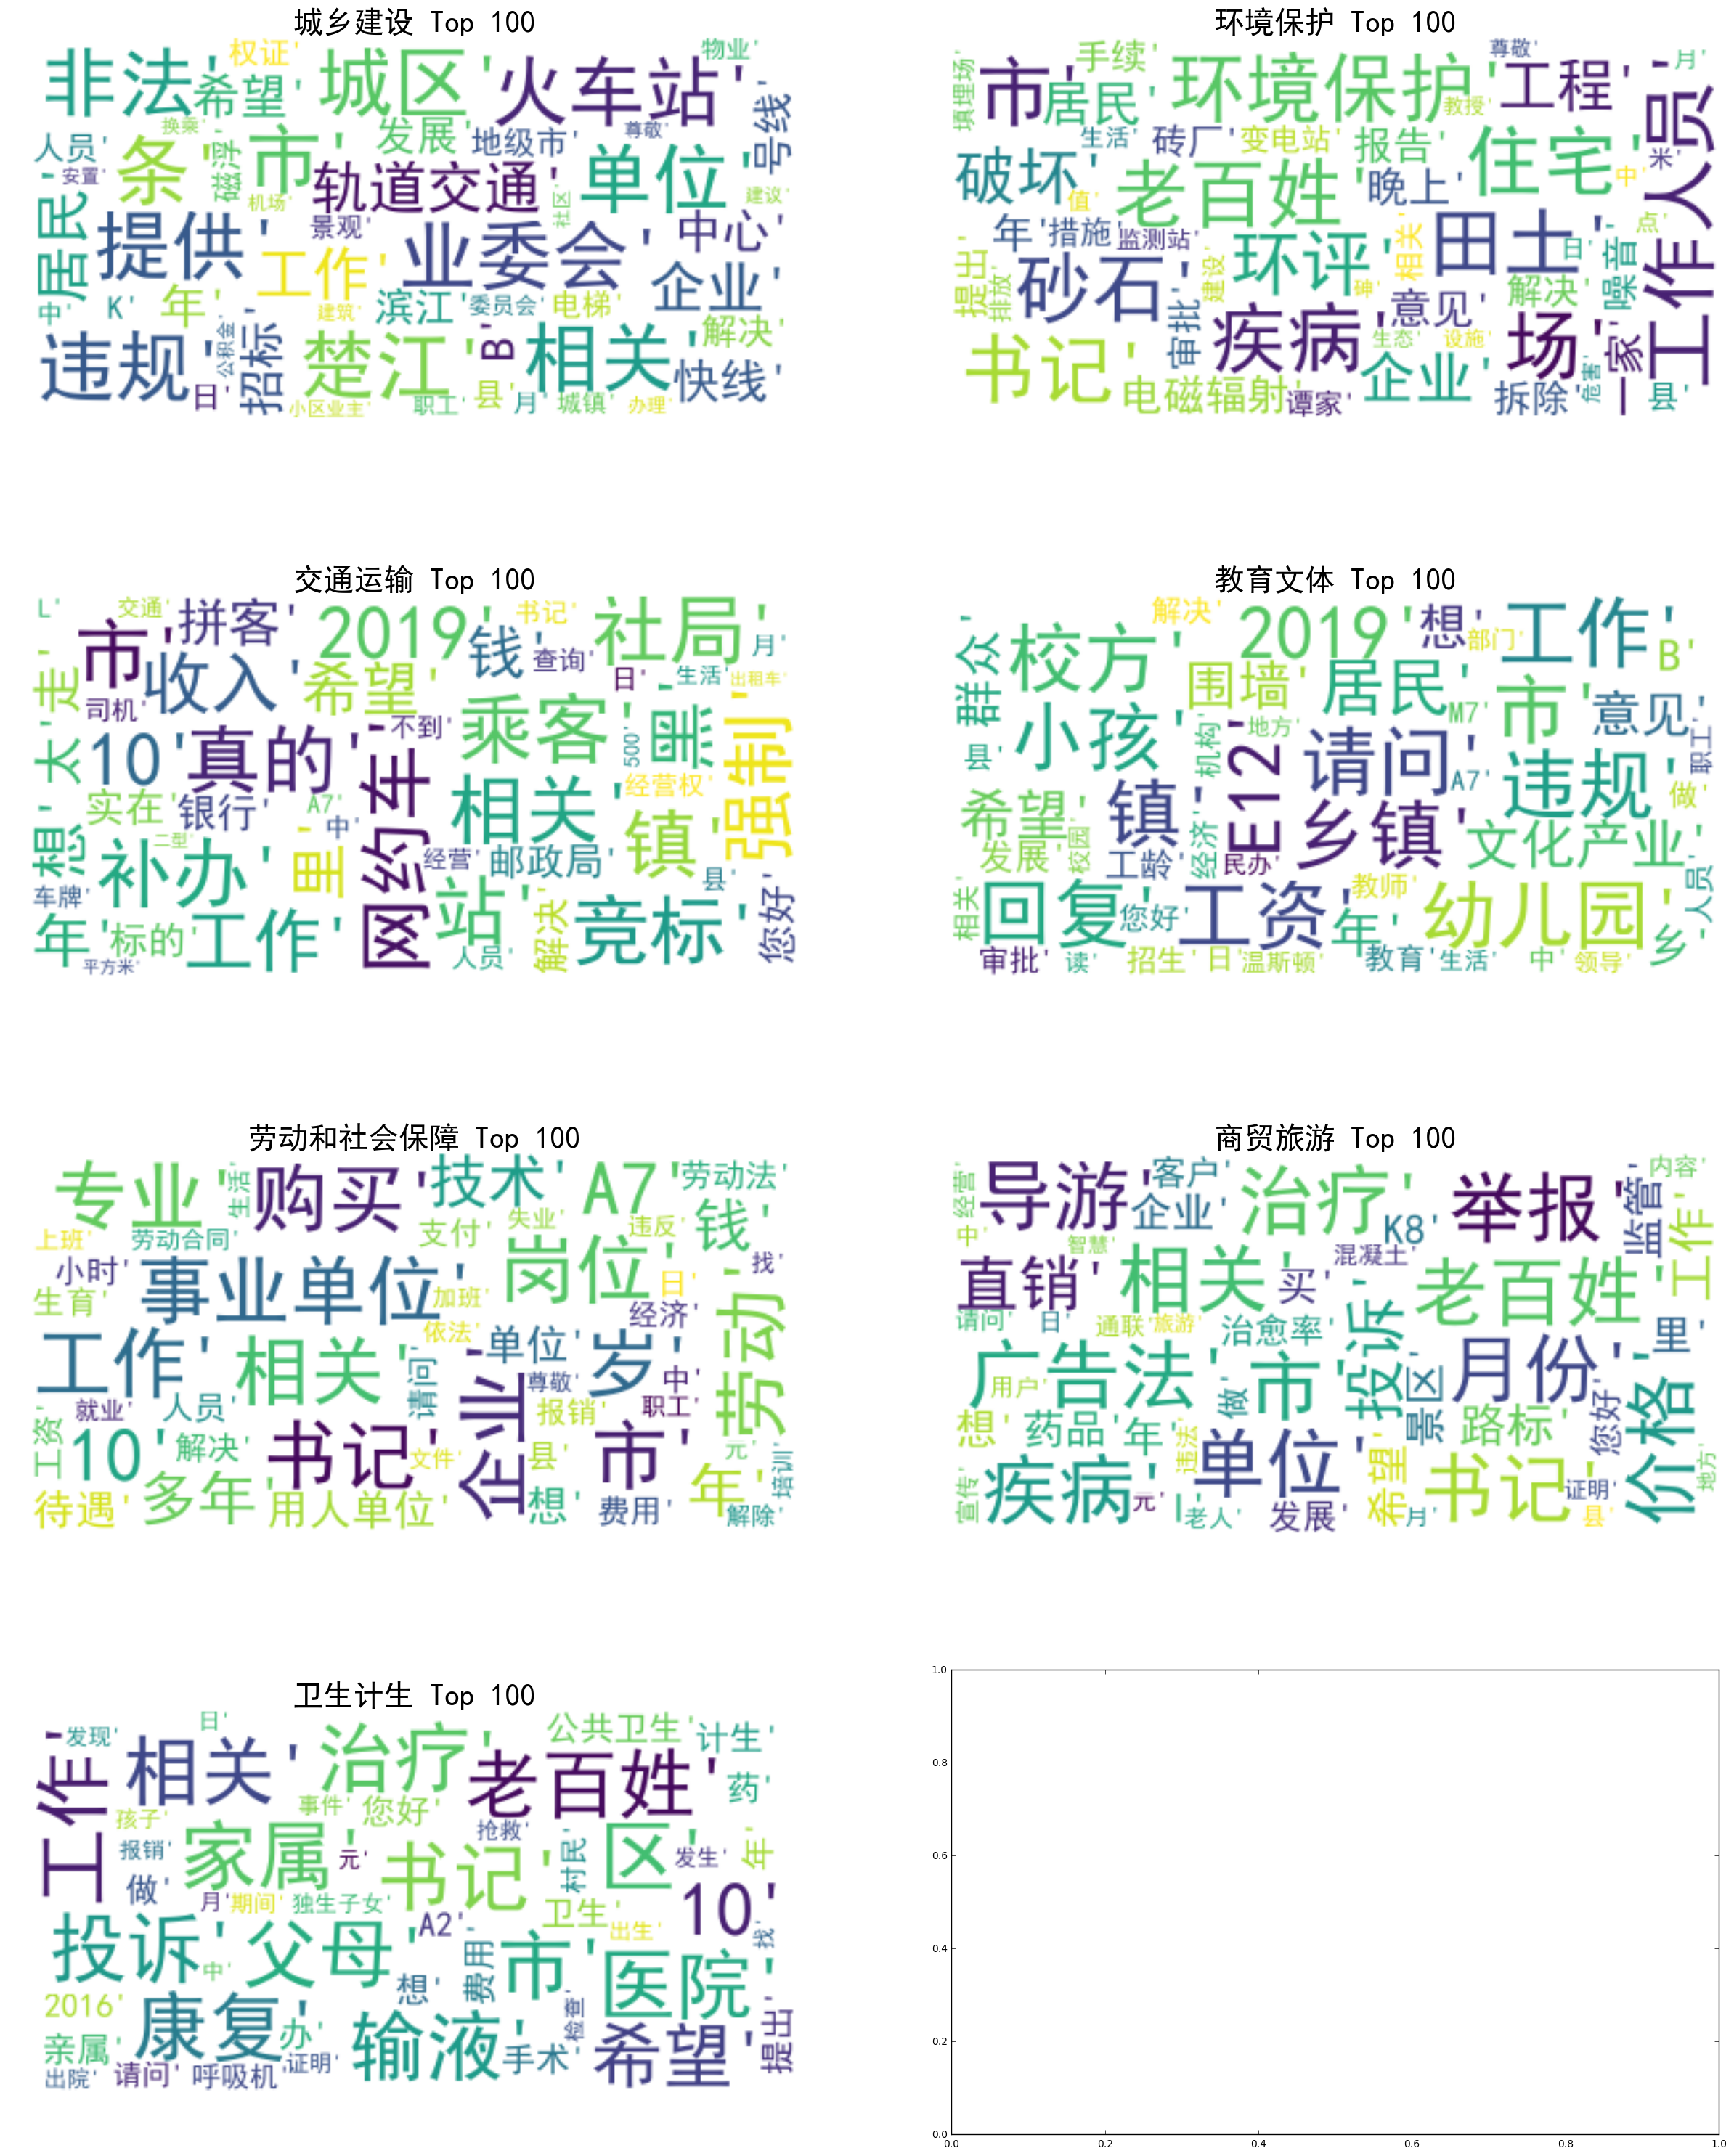

In [7]:
# 每个分类中罗列前100个高频词
# 画出这些高频词的词云
from collections import Counter
from wordcloud import WordCloud
 
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          font_path='simhei.ttf',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud
 
f_class_desc = dict()
for f_class in class_id_df.一级分类.values: 
    
    text = df.loc[df['一级分类']==f_class, 'cut_details']
    text = (' '.join(map(str,text))).split(' ')
    f_class_desc[f_class]=text
    
fig,axes = plt.subplots(4, 2, figsize=(30, 38))
k=0
for i in range(4):
    for j in range(2):
        if k==7:
            break
        f_class = id_to_class[k]
        most100=Counter(f_class_desc[f_class]).most_common(100)
        ax = axes[i, j]
        ax.imshow(generate_wordcloud(most100), interpolation="bilinear")
        ax.axis('off')
        ax.set_title("{} Top 100".format(f_class), fontsize=30,fontproperties="SimHei")
        k+=1
plt.show()

In [8]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
 
tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.cut_details)
labels = df.class_id
print(features.shape)
print('-----------------------------')
print(features)

(495, 56344)
-----------------------------
  (0, 33160)	0.14080838354369346
  (0, 32873)	0.14080838354369346
  (0, 33167)	0.14080838354369346
  (0, 50071)	0.14080838354369346
  (0, 21766)	0.14080838354369346
  (0, 51678)	0.14080838354369346
  (0, 7688)	0.13204297154932795
  (0, 51435)	0.14080838354369346
  (0, 35297)	0.14080838354369346
  (0, 3637)	0.14080838354369346
  (0, 18459)	0.14080838354369346
  (0, 33500)	0.14080838354369346
  (0, 55214)	0.14080838354369346
  (0, 21870)	0.14080838354369346
  (0, 39739)	0.14080838354369346
  (0, 54873)	0.14080838354369346
  (0, 26269)	0.14080838354369346
  (0, 48709)	0.14080838354369346
  (0, 51491)	0.14080838354369346
  (0, 13852)	0.14080838354369346
  (0, 7731)	0.14080838354369346
  (0, 51481)	0.14080838354369346
  (0, 13480)	0.14080838354369346
  (0, 51455)	0.14080838354369346
  (0, 35374)	0.14080838354369346
  :	:
  (494, 42736)	0.09777533018320295
  (494, 15134)	0.26252219309561475
  (494, 2011)	0.20334676414383393
  (494, 6297)	0.082481934

In [9]:
from sklearn.feature_selection import chi2
import numpy as np
 
N = 2
for f_class, class_id in sorted(class_to_id.items()):
    features_chi2 = chi2(features, labels == class_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(f_class))
    print(" Related words:{}".format('，'.join(unigrams[-N:])))  #最相关词
    print(" related phrases:{}".format('，'.join(bigrams[-N:])))  #最相关词组

# '交通运输':
 Related words:快递，出租车
 related phrases:出租车 公司，出租车 司机
# '劳动和社会保障':
 Related words:退休，职工
 related phrases:劳务 派遣，最低工资 标准
# '卫生计生':
 Related words:医生，医院
 related phrases:受理 请问，乡村 医生
# '商贸旅游':
 Related words:猪肉，广告
 related phrases:检验 检测，资质 认定
# '城乡建设':
 Related words:小区，业主
 related phrases:c4 廉租房，汽车 检测站
# '教育文体':
 Related words:文化，学校
 related phrases:培训 机构，学校 老师
# '环境保护':
 Related words:环保局，污染
 related phrases:环境 监测站，生态 破坏


In [9]:
class_to_id

{'交通运输': 2,
 '劳动和社会保障': 4,
 '卫生计生': 6,
 '商贸旅游': 5,
 '城乡建设': 0,
 '教育文体': 3,
 '环境保护': 1}

In [10]:
# 朴素贝叶斯分类器MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
 
X_train, X_test, y_train, y_test = train_test_split(df['cut_details'], df['class_id'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
 
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [81]:
# 测试分类方法
def myPredict(sec):
    format_sec=" ".join([w for w in list(jb.cut(remove_punctuation(sec))) if w not in stopwords])
    pred_cat_id=clf.predict(count_vect.transform([format_sec]))
#     print(id_to_class[pred_cat_id[0]],type(id_to_class[pred_cat_id[0]]))
    list1.append(id_to_class[pred_cat_id[0]])
    list2.append(class_id_df[class_id_df.一级分类==id_to_class[pred_cat_id[0]]].class_id.values[0])
    return list1,list2
    

In [12]:
myPredict("K市域轨道交通规划建议")

城乡建设


In [13]:
myPredict("A市新增500台出租车经营权竞标方案量身定制、指标内定")

交通运输


In [27]:
myPredict("B市民办学校贷款，政府是否有贴息补助")  #教育文体

城乡建设


In [28]:
myPredict("F5县新河乡小孩被学校劝退辍学并注销了学籍！")

教育文体


In [29]:
myPredict("K8县冷水镇党委负责人随意剥夺员工福利待遇")

劳动和社会保障


In [30]:
myPredict("J11市新华菜市场“瑞之康”欺骗老年人")   #社会保障

卫生计生


In [82]:
# 分类模型的评估方法-F分数(F-Score)
# TP(真阳性) FP(假阳性) FN(真阴性) TN(假阴性)
# df1=df.c_details.apply(myPredict)
F_table= df[['一级分类', 'class_id']]
F_table.columns=["实际","id"]
list1=[]  #预测一级分类
list2=[]   #预测一级分类ID
df.c_details.apply(myPredict)
F_table["预测"]=list1
F_table["预测id"]=list2
F_table


D:\Anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,实际,id,预测,预测id
0,城乡建设,0,城乡建设,0
1,城乡建设,0,城乡建设,0
2,城乡建设,0,城乡建设,0
3,城乡建设,0,城乡建设,0
4,城乡建设,0,城乡建设,0
5,城乡建设,0,城乡建设,0
6,城乡建设,0,劳动和社会保障,4
7,城乡建设,0,城乡建设,0
8,城乡建设,0,城乡建设,0
9,城乡建设,0,城乡建设,0


In [46]:
# TP=0
# FP=0
# for T in range(len(F_table)):
#     if F_table.预测[T]==F_table.实际[T]:
#         TP+=1
#     else:
#         FP+=1
# Precision=TP/(TP+FP)
# print("Precision(精确率)为：",Precision)


Precision(精确率)为： 0.8767676767676768


In [97]:
c_table=pd.DataFrame(np.zeros(49,dtype=int).reshape(7,7),index=range(7),columns=range(7))
c_table

,0,1,2,3,4,5,6
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0


In [98]:
for i in range(len(F_table)):
    c_table.iloc[F_table.id[i],F_table.预测id[i]]=c_table.iloc[F_table.id[i],F_table.预测id[i]]+1
c_table
# columns为 预测分类id
# index 为实际分类id

,0,1,2,3,4,5,6
0,92,0,0,2,7,0,0
1,6,26,0,0,1,0,0
2,8,0,42,1,4,0,0
3,1,0,0,90,5,0,0
4,0,0,0,1,102,0,1
5,12,0,0,0,7,29,0
6,1,0,0,1,3,0,53


In [103]:
# 当i==0时
# 实际为0的有92+2+7个  预测为0的有92个  所以TP=92  FP=9
# 实际为其他的有495-101=394  预测为0的有6+8+1+0+12+1=28  FN=28
TP=92
FP=9
FN=28
P=TP/(TP+FP)
R=TP/(TP+FN)
print(P,R)

0.9108910891089109 0.7666666666666667


In [126]:
Precision=[]
Recall=[]
for i in range(len(c_table)):
    TP=c_table.iloc[i,i].sum()
    FP=c_table.iloc[i,:].sum()-c_table.iloc[i,i]
    FN=c_table.iloc[:,i].sum()-c_table.iloc[i,i].sum()
    P=TP/(TP+FP)
    R=TP/(TP+FN)
    Precision.append(P)
    Recall.append(R)
print(Precision)
print(Recall)

[0.9108910891089109, 0.7878787878787878, 0.7636363636363637, 0.9375, 0.9807692307692307, 0.6041666666666666, 0.9137931034482759]
[0.7666666666666667, 1.0, 1.0, 0.9473684210526315, 0.7906976744186046, 1.0, 0.9814814814814815]


In [128]:
# 使用F-Score对分类方法进行评价
sum1=0
for i in range(len(Precision)):
    sum1=sum1+(Precision[i]*Recall[i]*2)/(Precision[i]+Recall[i])
print(sum1)

6.097534681492421


In [129]:
F1=sum1/len(Precision)
F1

0.8710763830703458